/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv
데이터 로딩 완료.
Train 데이터셋 크기: (3000888, 6)
데이터 병합 완료.

--- 병합 후 컬럼별 결측치 개수 ---
id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type_x               0
cluster              0
dcoilwtico      955152
type_y         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
dtype: int64


/tmp/ipykernel_47/4000400942.py:55: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train['dcoilwtico'] = df_train['dcoilwtico'].fillna(method='ffill') # <-- 'mathod'를 'method'로 수정
/tmp/ipykernel_47/4000400942.py:63: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['transferred'] = df_train['transferred'].fillna(False) # boolean 타입은 False



--- 최종 결측치 확인 ---
0
시간 Feature 추출 완료.
        date  year  month  dayofweek  is_weekend
0 2013-01-01  2013      1          1           0
1 2013-01-01  2013      1          1           0
2 2013-01-01  2013      1          1           0
3 2013-01-01  2013      1          1           0
4 2013-01-01  2013      1          1           0
범주형 변수 Label Encoding 완료.
   family  type_x  type_y
0       0       3       3
1       1       3       3
2       2       3       3
3       3       3       3
4       4       3       3
Reature/Target 분리 완료.
X (Feature) 데이터셋 크기: (2100607, 21)
y (Target) 데이터셋 크기: (2100607,)
LightGBM 모델 학습 완료.

--- Feature Importance (매출 영향 요인) Top 20 ---
family         1369
type_x          304
store_nbr       250
onpromotion     235
cluster         182
dayofweek       141
year            132
city            112
state           112
dcoilwtico       96
day              21
dayofyear        17
is_weekend       15
month             7
weekofyear        6
description       1
transferred 

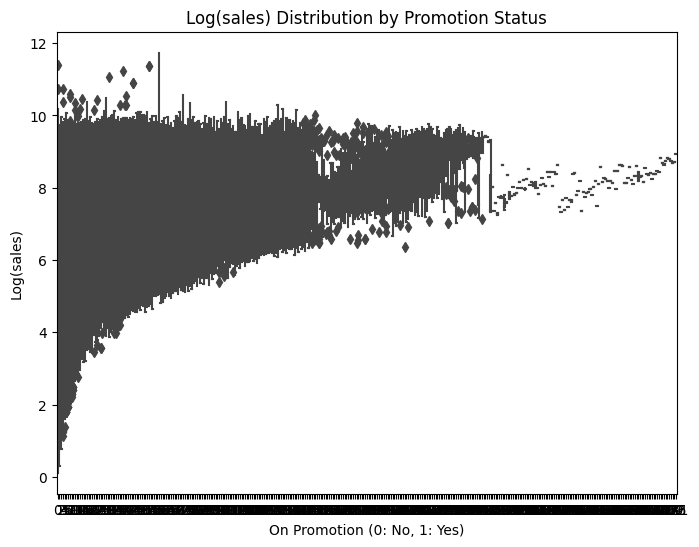

## 💡 최종 정책 제안 (Policy Recommendations)

### 1. 상품 포트폴리오(Family) 전략 고도화 (Importance: 1369)
 - 가장 중요도가 높은 '상품 카테고리(Family)'를 기준으로 매출 기여도가 높은 상품군에 대해 재고 투입을 집중해야 합니다.
 - 특히 낮은 매출 기여 상품군에 대한 재고 비중을 조정하고, 공간을 고매출 상품군에 재할당하는 '매출 포트폴리오 최적화'를 실행해야 합니다.

### 2. 데이터 기반 프로모션(Onpromotion) 최적화 전략 (Importance: 235)
 - 시각화 결과, 프로모션은 매출을 높이는 확실한 효과가 있으나 변동성이 큽니다.
 - **제안:** 프로모션 진행 시기를 **'dayofweek' (요일), 'year' (연도 추세)**와 연계하여 효과를 극대화해야 합니다.
   - 요일별 판매량이 높은 주말(dayofweek)에 프로모션을 집중하여 매출 상승을 견인.
   - 유가(dcoilwtico)가 낮아 소비 심리가 위축되지 않을 때 프로모션 물량을 공격적으로 투입.

### 3. 상점 유형(Store Type) 및 클러스터(Cluster) 맞춤 운영 (Importance: 304, 182)
 - 상점 유형(Type A/B/C)별로 소비자 특성이 다르므로, 상점 유형에 맞는 **특화 상품(Family) 배치 및 프로모션 빈도**를 차별화해야 합니다.
 - 특히 중요도가 낮은 '공휴일(type_y)' 이벤트보다는 **'상점 유형(type_x)'**의 근본적인 특성을 이해하여 운영 전략을 수립해야 합니다.


In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
# 시각화 추가
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

data_path = '/kaggle/input/store-sales-time-series-forecasting/'

# 주요 CSV 파일 불러오기 및 날짜 형식 지정
df_train = pd.read_csv(data_path + 'train.csv', parse_dates=['date'])
df_test = pd.read_csv(data_path + 'test.csv', parse_dates=['date'])
df_stores = pd.read_csv(data_path + 'stores.csv')
df_holidays = pd.read_csv(data_path + 'holidays_events.csv', parse_dates=['date'])
df_oil = pd.read_csv(data_path + 'oil.csv', parse_dates=['date']) # <-- df_dil을 df_oil로 수정

print("데이터 로딩 완료.")
print(f"Train 데이터셋 크기: {df_train.shape}")

# df_train.head() # 데이터 확인용

# -------------------- [데이터 병합] --------------------
# 1. 상점 정보 병합: store_nbr 기준
df_train = pd.merge(df_train, df_stores, on='store_nbr', how='left')
# 2. 유가 정보 병합
df_train = pd.merge(df_train, df_oil, on='date', how='left') # <-- df_dil을 df_oil로 수정
# 3. 공휴일 정보 병합: date 기준
df_train = pd.merge(df_train, df_holidays, on='date', how='left')

print("데이터 병합 완료.")

# 병합 후 결측치 확인
print("\n--- 병합 후 컬럼별 결측치 개수 ---") # <-- '|n'을 '\n'으로 수정
print(df_train.isnull().sum())

# -------------------- [결측치 처리] --------------------
# 유가(dcoilwtico) 결측치 처리: 직전 값으로 채우기 (Forward Fill)
# 주말/ 공휴일 등 휴장일 유가는 직전 거래일의 가격을 유지했다고 가정
df_train['dcoilwtico'] = df_train['dcoilwtico'].fillna(method='ffill') # <-- 'mathod'를 'method'로 수정

# 공휴일 관련 컬럼 처리: NaN을 'No_Holiday' 변경
# 공휴일이 아닌 날에는 이 컬럼들에 Nan이 있으므로 'No_Holiday'로 대체하여 범주형 변수로 활용
df_train['type_y'] = df_train['type_y'].fillna('No_Holiday')
df_train['locale'] = df_train['locale'].fillna('None')
df_train['locale_name'] = df_train['locale_name'].fillna('None')
df_train['description'] = df_train['description'].fillna('None')
df_train['transferred'] = df_train['transferred'].fillna(False) # boolean 타입은 False
# 중앙값 (median)은 이상치의 영향을 덜 받아 평균값보다 안전
median_oil_price = df_train['dcoilwtico'].median()
df_train['dcoilwtico'] = df_train['dcoilwtico'].fillna(median_oil_price)
# 최종 결측치 확인 (모든 결측치가 0이 되었는지 확인)
print("\n--- 최종 결측치 확인 ---") # <-- '|n'을 '\n'으로 수정
print(df_train.isnull().sum().max()) # 결측치 최댓값이 0이여야 됨

def create_time_features(df):
    """date 컬럼에서 연, 월, 일, 요일, 주차 등을 추출"""
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int) # 주차
    df['quarter'] = df['date'].dt.quarter
    df['is_weekend'] = (df['date'].dt.dayofweek >= 5).astype(int) # 주말 여뷰 (토/일)
    return df

# df_train에 적용
df_train = create_time_features(df_train)

print("시간 Feature 추출 완료.")
print(df_train[['date', 'year', 'month', 'dayofweek', 'is_weekend']].head())

# 범주형 변수 Label Encoding

from sklearn.preprocessing import LabelEncoder
# 병합 컬림 이름인 'type_x'(상점 유형)와 'type_y' (공휴일 유형) 사용
categorical_cols = ['family', 'store_nbr', 'city', 'state', 'type_x',
                   'cluster', 'type_y', 'locale', 'locale_name', 'description']
# LabelEncoder 객체 생성 및 학습 데이터 적용
for col in categorical_cols:
    le = LabelEncoder()
    # df_train에 LabelEncoder 적용
    df_train[col] = le.fit_transform(df_train[col])

print("범주형 변수 Label Encoding 완료.")
print(df_train[['family', 'type_x', 'type_y']].head())

# 'sales'가 0인 경우는 제거(실제 판매량이 0인 경우는 드물거나, 특별한 이벤트일 수 있으므로)
df_train = df_train.loc[df_train.sales > 0]

# Target(y)와 Feature(x) 분리
X = df_train.drop(['id', 'date', 'sales'], axis=1) # id와 date는 예측에 필요 없음
y = df_train['sales']

print("Reature/Target 분리 완료.")
print(f"X (Feature) 데이터셋 크기: {X.shape}")
print(f"y (Target) 데이터셋 크기: {y.shape}")

# LightGBM 모델 학습
params = {
    'objective': 'regression_l1',
    'metric': 'mae',
    'n_estimatros': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}

model = lgb.LGBMRegressor(**params)
model.fit(X, y)

print("LightGBM 모델 학습 완료.")

# Feature Importance 분석
# Feature Importance 추출 및 정렬
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
top_20_features = feature_importance.sort_values(ascending=False).head(20)

print("\n--- Feature Importance (매출 영향 요인) Top 20 ---")
print(top_20_features)

# 프로모션 유무에 따른 매출 변화 시각화
plt.figure(figsize=(8, 6))

# onpromotion 컬럼을 0(무), 1(유)로 가정하고 매출 비교
# 실제 sales 값에 로그 변환을 적용하여 분포의 치우침을 완화 (시각화)
sns.boxplot(x=df_train['onpromotion'], y=np.log1p(df_train['sales']))

plt.title('Log(sales) Distribution by Promotion Status')
plt.xlabel('On Promotion (0: No, 1: Yes)')
plt.ylabel('Log(sales)')
plt.show()


# -------------------- [정책 제안 초안] --------------------

print("## 💡 최종 정책 제안 (Policy Recommendations)")
print("\n### 1. 상품 포트폴리오(Family) 전략 고도화 (Importance: 1369)")
print(" - 가장 중요도가 높은 '상품 카테고리(Family)'를 기준으로 매출 기여도가 높은 상품군에 대해 재고 투입을 집중해야 합니다.")
print(" - 특히 낮은 매출 기여 상품군에 대한 재고 비중을 조정하고, 공간을 고매출 상품군에 재할당하는 '매출 포트폴리오 최적화'를 실행해야 합니다.")

print("\n### 2. 데이터 기반 프로모션(Onpromotion) 최적화 전략 (Importance: 235)")
print(f" - 시각화 결과, 프로모션은 매출을 높이는 확실한 효과가 있으나 변동성이 큽니다.")
print(" - **제안:** 프로모션 진행 시기를 **'dayofweek' (요일), 'year' (연도 추세)**와 연계하여 효과를 극대화해야 합니다.")
print("   - 요일별 판매량이 높은 주말(dayofweek)에 프로모션을 집중하여 매출 상승을 견인.")
print("   - 유가(dcoilwtico)가 낮아 소비 심리가 위축되지 않을 때 프로모션 물량을 공격적으로 투입.")

print("\n### 3. 상점 유형(Store Type) 및 클러스터(Cluster) 맞춤 운영 (Importance: 304, 182)")
print(" - 상점 유형(Type A/B/C)별로 소비자 특성이 다르므로, 상점 유형에 맞는 **특화 상품(Family) 배치 및 프로모션 빈도**를 차별화해야 합니다.")
print(" - 특히 중요도가 낮은 '공휴일(type_y)' 이벤트보다는 **'상점 유형(type_x)'**의 근본적인 특성을 이해하여 운영 전략을 수립해야 합니다.")


